### Instituto Tecnológico de Costa Rica (ITCR)
### Escuela de Computación
### Curso: Inteligencia Artificial
 
### Cuarta tarea programada 2022-I


Estudiantes: Juan Ignacio Navarro Navarro

### 1.1) Implementación del algoritmo K-means sin bibliotecas

Importación de la librerías necesarias para mostrar los resultados del análisis.

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy.random import uniform
from sklearn.datasets import make_blobs
import seaborn as sns
import random
import pandas as pd
import pandasql as sqldf

Definición de la clase que implementa KMeans. Además también se crea un método que define la función euclidea.

In [3]:
# Funcion para calculo de la distancia entre puntos
def euclidean(point, data):
    """
    Descipcion: distancia entre puntos de informacion
    para poder realizar la clasificacion en clusters
    al calcular la distancia total con un conjunto de
    puntos

    Entreda:
        point -> es un vector de dimension m que representa un dato
        data -> es arreglo que contiene el resto de los puntos del cluster
    """
    return np.sqrt(np.sum((point - data)**2, axis=1))

# clase para el calculo de K medias
class KMeans:
    def __init__(self, n_clusters=8, max_iter=300):
        """
        Descripcion: se definen los cluster iniciales y un maximo de iteraciones
        en los calculos del algoritmo
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X_train):
        """
        Descripcion: se definen los centroides que son un punto de los dados 
        con respecto a los cuales se calculan las ditancias para conocer si es una
        buena referencia

        input:
            -> X_train : son los datos de entrada del algoritmo
        """

        self.centroids = [random.choice(X_train)]
        for _ in range(self.n_clusters-1):
            # Se calculan las ditancias de los puntos hacia los centroides
            dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
            # Se normalizan estas distancias
            dists /= np.sum(dists)
            # Se escogen los puntos restantes basados en estas distancias
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
            self.centroids += [X_train[new_centroid_idx]]

        # Ahora se itera para ajustar los centroides hasta que converjan
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # Se ordenan los datos asignangolos al centroide mas cercano
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():
                    self.centroids[i] = prev_centroids[i]
            iteration += 1

    def evaluate(self, X):
        """
        descripcion: funcion de evaluacion donde se asocian los puntos
        al centroide de su cluster
        """
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return centroids, centroid_idxs


Prueba del algortimo con datos generados artificialmente

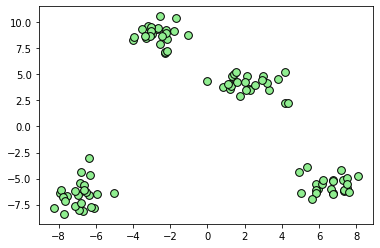

          1         2          3         4  Cluster
0  6.724657 -6.430379  -5.388381 -6.478967        1
1  4.935718 -4.399345  -6.478041 -5.094093        1
2 -6.956729 -6.538958  -8.561637  8.150706        3
3  4.144456  5.193917 -11.107680  8.913963        0
4 -6.357686 -6.583125  -8.587835  7.669971        3


In [4]:
# Se crea un arreglo de datos aleatorios con make_blobs que contiene la cantidad
# de centros indicada junto con la cantidad de caracteristicas dada como features
centers = 4
features = 4
X_train, true_labels = make_blobs(n_samples=100, centers=centers, random_state=42, n_features=features)

# Se grafican los datos
plt.scatter(
   X_train[:, 0], X_train[:, 1],
   c='lightgreen', marker='o',
   edgecolor='black', s = 60
)
plt.show()

# Se aplica Kmeans
kmeans = KMeans(n_clusters=centers)
kmeans.fit(X_train)
df = pd.DataFrame(X_train, columns=['1', '2', '3', '4'])

# Se imprimen los datos con el cluster escogido para cada uno
df['Cluster'] = kmeans.evaluate(X_train)[1]
print(df.head())


### 1.2) Implementación de DBSCAN sin bibliotecas

Se importan las bibliotecas necesarias para la población y graficación de los datos

In [5]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

Se crean los métodos necesarios para el desarrollo del algoritmo

In [6]:
def check_core_point(eps,minPts, df, index):
    """
    Descripcion: clasificación de los puntos como core, borde o ruido.
    Esto lo hace dependiendo de los vecinos que se tienen tomando como
    parámetro el radio eps y el minimo de puntos
    """
    # Se obtienen los puntos
    x, y = df.iloc[index]['X']  ,  df.iloc[index]['Y']
    
    # Se revisa si los puntos están en el radio dado
    temp =  df[((np.abs(x - df['X']) <= eps) & (np.abs(y - df['Y']) <= eps)) & (df.index != index)]
    
    #se revisa la cantidad de puntos que se encuentran dentro del radio
    if len(temp) >= minPts:
        #formato del return (dataframe, is_core, is_border, is_noise)
        return (temp.index , True, False, False)
    
    elif (len(temp) < minPts) and len(temp) > 0:
        #formato del return (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, True, False)
    
    elif len(temp) == 0:
        #formato del return (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, False, True)

Ahora se define la función principal del algoritmo

In [7]:
def cluster_with_stack(eps, minPts, df):
    """
    Descripcion: Esta funcion retorna una lista con todos
    los puntos y los respectivos clusters escogidos para cada uno
    """
    #Cantidad incial de clusters
    C = 1
    # se necesita una pila y una lista de datos no visitados
    current_stack = set()
    unvisited = list(df.index)
    clusters = []
    
    while (len(unvisited) != 0): # hasta que todos los puntos sean visitados

        # identificador del primer punto como un cluster
        first_point = True
        
        # primero se escoge un punto aleatorio 
        current_stack.add(random.choice(unvisited))
        
        while len(current_stack) != 0: # esta parte se corre hasta el cluster esté completo
            curr_idx = current_stack.pop()
            
            # se revisa si corresponde a un punto core, border o ruido
            neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx)
            
            # en el caso de que se empiece on un borde se debe pasar esta revisión
            if (isborder & first_point):
                #en este caso se renombran los vecinos como ruido

                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                
                #también se marca como visitado
                unvisited.remove(curr_idx)
                unvisited = [e for e in unvisited if e not in neigh_indexes]
    
                continue
                
            unvisited.remove(curr_idx) #cuando se termina el analisis se quita de la lista de non visitados
            
            
            neigh_indexes = set(neigh_indexes) & set(unvisited) 
            
            if iscore: #si el punto actual es core
                first_point = False
                
                clusters.append((curr_idx,C)) #se le asigna un cluster
                current_stack.update(neigh_indexes) # se añaden los vecinos al cluster

            elif isborder:# si el punto actual es un borde
                clusters.append((curr_idx,C))
                
                continue

            elif isnoise: #si el punto actual es un ruido
                clusters.append((curr_idx, 0))
                
                continue
                
        if not first_point:
            #ahora se incrementa el numero de clusters
            C+=1
        
    return clusters

Prueba del algoritmo con datos generados artificialmente por medio de bibliotecas

          X         Y
0  1.006780  5.117322
1  7.961095  4.321666
2  8.541570  1.251254
3  5.134048  6.202055
4  5.862344  2.387744
len data 200
          X         Y
0  1.006780  5.117322
1  7.961095  4.321666
2  8.541570  1.251254
3  5.134048  6.202055
4  5.862344  2.387744
len clustered 209
    idx  cluster
0   141        1
1   151        1
2   105        1
3    45        1
4    83        1
..  ...      ...
95  136        2
96   74        2
97   11        2
98  140        2
99   79        2

[100 rows x 2 columns]


Text(0, 0.5, 'Y')

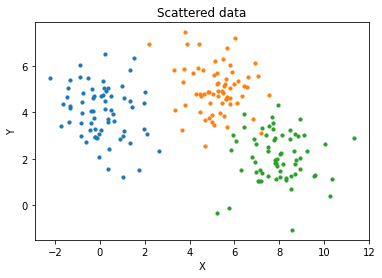

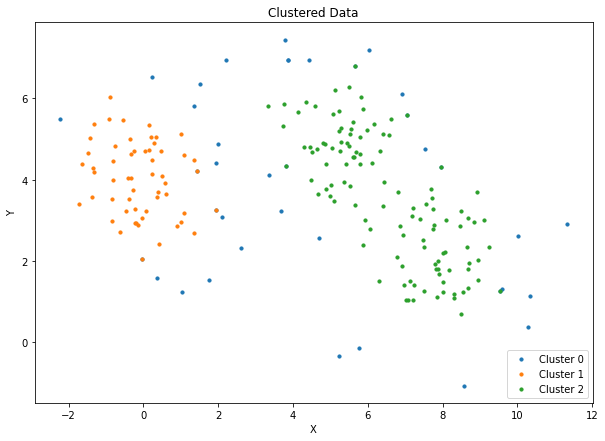

In [8]:

# Definicion de los centros para generar los datos de prueba
centers = [(0, 4), (5, 5) , (8,2)]
cluster_std = [1.2, 1, 1.1]

# Se crea una cantidad de puntos, en este caso el ejemplo
# se inicializa con 2 valores en cada dato porque son puntos
X, y= make_blobs(n_samples=200, cluster_std=cluster_std, centers=centers, n_features=2, random_state=1)

# graficación de los datos clasificados inicialemnte
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=10, label="Cluster2")
plt.scatter(X[y == 2, 0], X[y == 2, 1], s=10, label="Cluster3")
plt.title("Scattered data")
plt.xlabel('X')
plt.ylabel('Y')

# parametro del radio
eps = 0.6
# parametro del minimo de vecinos
minPts = 4

# Mostrar los datos
data = pd.DataFrame(X, columns = ["X", "Y"] )
print(data.head())
print("len data", len(data))
clustered = cluster_with_stack(eps, minPts, data)
print(data.head())
print("len clustered", len(clustered))
new_clustered = []
for i in range(len(clustered)):
    for cluster in clustered:
        if (i == cluster[0]):
            new_clustered.append(cluster[1])
            break

idx , cluster = list(zip(*clustered))


# Ahora que se realizó el análisis, note como se muestra 
cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])
print(cluster_df.head(100))

# Ahora que ya se realizó el analisis se muestra la distribución de los
# clusters, note que es diferente
plt.figure(figsize=(10,7))
for clust in np.unique(cluster):
    plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], s=10, label=f"Cluster{clust}")
plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
plt.title('Clustered Data')
plt.xlabel('X')
plt.ylabel('Y')

### 2.1) y 2.2) Carga y selección de los datos a anlizar

In [108]:
df = pd.read_csv('oij.csv')
df = df.drop(columns=["SubDelito","Fecha","Hora","Nacionalidad","Provincia","SubVictima", "Distrito", ";;"])
df["Canton"] = df["Canton"].str.lower()

#mysql = lambda q: sqldf(q, locals())
df = sqldf.sqldf("SELECT COUNT(Delito) AS CantidadDelito, Canton FROM df GROUP BY Canton")
#mysql()

print(df.head())



   CantidadDelito      Canton
0              44   abangares
1              26      acosta
2            1115    alajuela
3             216  alajuelita
4              23    alvarado


In [99]:
def normalize(list):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    new_list = []
    for s in list:
        for a, b in replacements:
            s = s.replace(a, b).replace(a.upper(), b.upper())
        new_list.append(s)
    return new_list


df = pd.read_excel('inec.xls')
df = df.drop([0, 1, 2, 3], axis=0)
df = df.drop(["Unnamed: 0"], axis=1)
df["Canton"] = normalize(df["Canton"].str.lower())
df = df.drop(columns=["Población de 15 años y más", "Tasa neta de participación", "Sector Primario", "Sector Secundario", "Sector Terciario"], axis = 1)
print(df.head())


       Canton  Tasa de ocupación  Tasa de desempleo abierto  \
4    puriscal          49.103748                   3.071150   
5     tarrazu          49.737288                   2.782839   
6      aserri          52.686884                   3.249831   
7        mora          53.433918                   3.229241   
8  goicoechea          54.698079                   3.689298   

   Porcentaje de población económicamente inactiva  \
4                                        49.340421   
5                                        48.838983   
6                                        45.543368   
7                                        44.782992   
8                                        43.206645   

   Relación de dependencia económica  
4                           1.527686  
5                           1.696704  
6                           1.449729  
7                           1.332683  
8                           1.238161  


## Referencias

- Ayuda algoritmo KMeans: https://datascience.stackexchange.com/questions/48693/perform-k-means-clustering-over-multiple-columns

- https://towardsdatascience.com/create-your-own-k-means-clustering-algorithm-in-python-d7d4c9077670


- Ayuda algoritmo DBSCAN: https://github.com/Moosa-Ali/DBscan-Clustering-Implementation/blob/main/DBSCAN%20implementation.ipynb
